In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os,sys,time,math
import numpy as np
import pandas as pd
from six.moves import xrange  
import gdal
from matplotlib import pyplot as plt
#import data_input as dataset
from utils import geotiling as gt

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from scipy.stats import pearsonr

In [3]:
df_annos = pd.read_csv("/home/timhu/data/all_jpgpaths_clean_538k_May17.csv", index_col=0)
image_composite = gt.ImageComposite("/home/timhu/data/lspop2011.tif", 1)

In [4]:
df_res = df_annos[df_annos.partition == 'test']
df_res = df_res[['village_id','state_id','district_id','subdistrict_id','area', 'longitude', 'latitude', 'secc_pop', 'pop_density','pop_density_log2',]]
df_res.area = df_res.area / 1e6 # convert area from m2 to km2
df_res.index = range(len(df_res))
df_res.tail()

,village_id,state_id,district_id,subdistrict_id,area,longitude,latitude,secc_pop,pop_density,pop_density_log2
57562,566741,33,631,5891,9.387259,78.236484,12.381329,2774,295.506926,8.207048
57563,566742,33,631,5891,14.659993,78.212243,12.354418,6138,418.690507,8.709740
57564,566743,33,631,5891,12.207912,78.189224,12.364577,5827,477.313385,8.898793
57565,566744,33,631,5891,14.200096,78.176433,12.334345,4543,319.927418,8.321601
57566,566745,33,631,5891,13.059874,78.237173,12.334514,3564,272.896967,8.092213


In [5]:
def get_landscan_density(lat, long, area):
    cell_size = math.cos(math.radians(lat))
    width = height = max(round(math.sqrt(area / cell_size)),1)
    col, row = image_composite.geoprops.lonlat2colrow(long, lat)
    x = image_composite.gdal_dataset.ReadAsArray(col - width//2, row - height//2, width, height)
    total_persons = sum(sum(x))
    pop_density_landscan = total_persons *1.0/ (width*height*cell_size)
    return pop_density_landscan

In [12]:
ls_density_array = []
for (i, row) in df_res.iterrows():
    ls_density = get_landscan_density(row.latitude, row.longitude, row.area)
    ls_density_array.append(ls_density)
df_res['pre_density'] = ls_density_array
df_res = df_res[df_res.pre_density > 0]
df_res['pre_density_log2'] = np.log2(df_res.pre_density)
df_res.head()

In [33]:
df_res.to_csv('/home/timhu/data/landscan_comparison_all_538k_May17')

In [17]:
# lat = 11.773185
# long = 78.368497
# area = 9

In [18]:
# cell_size = math.cos(math.radians(lat))
# width = height = max(round(math.sqrt(area / cell_size)),1)
# col, row = image_composite.geoprops.lonlat2colrow(long, lat)
# x = image_composite.gdal_dataset.ReadAsArray(col - width//2, row - height//2, width, height)
# total_persons = sum(sum(x))
# pop_density_landscan = total_persons *1.0/ (width*height*cell_size)

### 0. raw log2 density 

In [8]:
df_res = pd.read_csv('/home/timhu/data/landscan_comparison_all_538k_May17.csv')

In [10]:
r2 = r2_score(df_res.pop_density_log2.values, df_res.pre_density_log2.values)
p = pearsonr(df_res.pop_density_log2.values, df_res.pre_density_log2.values)[0]
print(r2)
print(p)

-0.827637877189
0.427587531975


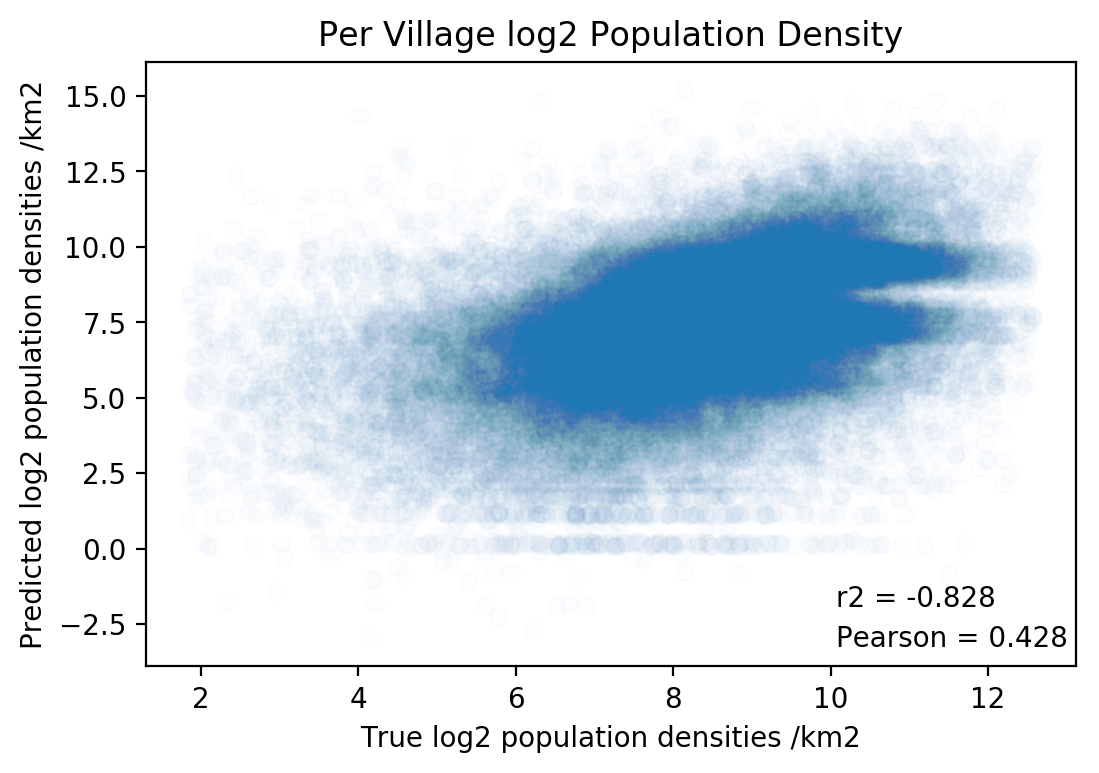

In [11]:
plt.figure(dpi=200)
plt.title("Per Village log2 Population Density")
plt.ylabel("Predicted log2 population densities /km2")
plt.xlabel("True log2 population densities /km2")

plt.figtext(0.7, 0.2, "r2 = %.3f" % r2)
plt.figtext(0.7, 0.15, "Pearson = %.3f" % p)
plt.scatter(df_res.pop_density_log2.values, df_res.pre_density_log2.values, alpha=0.01)
plt.show()

### 2. Direct Average Aggregation comparison

In [30]:
df_direct_log2_ave = df_res.groupby('subdistrict_id')['pop_density_log2', 'pre_density_log2'].agg(np.mean)
true_subdistrict_vals = df_direct_log2_ave.pop_density_log2.values
pred_subdistrict_vals = df_direct_log2_ave.pre_density_log2.values

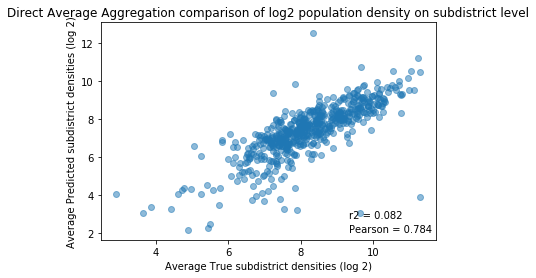

In [31]:
plt.title("Direct Average Aggregation comparison of log2 population density on subdistrict level")
plt.ylabel("Average Predicted subdistrict densities (log 2)")
plt.xlabel("Average True subdistrict densities (log 2)")
r2 = r2_score(true_subdistrict_vals, pred_subdistrict_vals)
p = pearsonr(true_subdistrict_vals, pred_subdistrict_vals)[0]
plt.figtext(0.7, 0.2, "r2 = %.3f" % r2)
plt.figtext(0.7, 0.15, "Pearson = %.3f" % p)
plt.scatter(true_subdistrict_vals, pred_subdistrict_vals, alpha=0.5)
plt.show()

### 3. Weighted Average Aggregation comparison

In [26]:
df_res['pred_pop'] = df_res.pre_density * df_res.area
df_weighted_sum = df_res.groupby('subdistrict_id')['secc_pop', 'pred_pop','area'].agg(np.sum)
df_weighted_sum['secc_pop_density'] = df_weighted_sum.secc_pop / df_weighted_sum.area
df_weighted_sum['pred_pop_density'] = df_weighted_sum.pred_pop / df_weighted_sum.area
# df_weighted_sum['secc_pop_density_log2'] = np.log2(df_weighted_sum.secc_pop_density)
# df_weighted_sum['pred_pop_density_log2'] = np.log2(df_weighted_sum.pred_pop_density)
df_weighted_sum.head()

,secc_pop,pred_pop,area,secc_pop_density,pred_pop_density
subdistrict_id,,,,,
22,161483,77160.944677,510.430255,316.366435,151.168439
26,60141,79177.680728,325.216946,184.925788,243.461117
34,145034,224435.909011,189.435110,765.613092,1184.764058
37,62879,23760.000903,181.121729,347.164309,131.182498
40,44164,1380.011619,60.718620,727.355140,22.727981


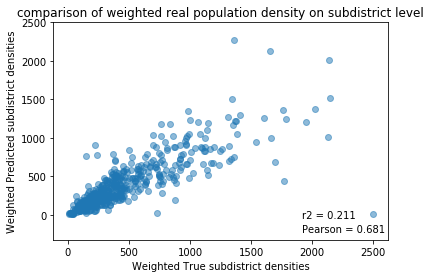

In [32]:
true_subdistrict_vals = df_weighted_sum.secc_pop_density.values
pred_subdistrict_vals = df_weighted_sum.pred_pop_density.values

plt.title("comparison of weighted real population density on subdistrict level")
plt.ylabel("Weighted Predicted subdistrict densities")
plt.xlabel("Weighted True subdistrict densities")
r2 = r2_score(true_subdistrict_vals, pred_subdistrict_vals)
p = pearsonr(true_subdistrict_vals, pred_subdistrict_vals)[0]
plt.figtext(0.7, 0.2, "r2 = %.3f" % r2)
plt.figtext(0.7, 0.15, "Pearson = %.3f" % p)
plt.scatter(true_subdistrict_vals, pred_subdistrict_vals, alpha=0.5)
plt.ylim(ymax=2500)
plt.show()

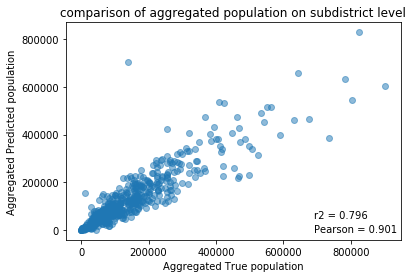

In [28]:
true_subdistrict_vals = df_weighted_sum.secc_pop.values
pred_subdistrict_vals = df_weighted_sum.pred_pop.values

plt.title("comparison of aggregated population on subdistrict level")
plt.ylabel("Aggregated Predicted population")
plt.xlabel("Aggregated True population")
r2 = r2_score(true_subdistrict_vals, pred_subdistrict_vals)
p = pearsonr(true_subdistrict_vals, pred_subdistrict_vals)[0]
plt.figtext(0.7, 0.2, "r2 = %.3f" % r2)
plt.figtext(0.7, 0.15, "Pearson = %.3f" % p)
plt.scatter(true_subdistrict_vals, pred_subdistrict_vals, alpha=0.5)

In [ ]:
# def get_landscan_density(lat, long, area):
#     area_km2 = area/(10**6)
#     size_box = int(area/(10**6)) + 1
#     col, row = image_composite.geoprops.lonlat2colrow(lon, lat)
#     x = image_composite.gdal_dataset.ReadAsArray(col - int(size_box/2), row - int(size_box/2), size_box, size_box)
#     total_persons = sum(sum(x))
#     pop_density_landscan = total_persons *1.0/ (size_box*size_box*math.cos(math.radians(lat)))
#     return abs(pop_density_landscan)